In [62]:
import os, sys, time, resource, re, gc, shutil
from multiprocess import Pool
from functools import partial
from tabulate import tabulate
from urllib.parse import urlparse, parse_qsl

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mongoengine.queryset.visitor import Q
import django
from django.db.models import Count
sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from scoping.models import *
from tmv_app.models import *
from utils.text import *
from sklearn.feature_extraction.text import *
from sklearn.decomposition import NMF

from run_id import run_id
run_id = 383
stat = RunStats.objects.get(pk=run_id)
q = stat.query
print(q.title)

wos_all_2016


In [70]:
doc_ids = list(set(Doc.objects.filter(doctopic__topic__run_id=run_id).values_list('id',flat=True)))
docs = Doc.objects.filter(id__in=doc_ids)

print(docs.count())

32828


In [71]:
abstracts, docsizes, ids = proc_docs(docs, stoplist)

tfidf_vectorizer = TfidfVectorizer(
        max_df=stat.max_df,
        min_df=stat.min_freq,
        max_features=500000,
        ngram_range=(stat.ngram,stat.ngram),
        tokenizer=snowball_stemmer(),
        stop_words=stoplist
    )
tfidf = tfidf_vectorizer.fit_transform(abstracts)

In [112]:
print(tfidf.shape)
print(len(m.col))
print(len(m.row))
print(len(m.data))

(32828, 98419)
2959482
2959482
2959482


In [106]:
from scipy.sparse import find
print(find(m))
print(len(find(m)[2]))


(array([ 9998, 11377, 11961, ..., 25787, 20151,  8825], dtype=int32), array([    0,     0,     0, ..., 98416, 98417, 98418], dtype=int32), array([ 0.1695896 ,  0.14415808,  0.50692067, ...,  0.10667244,
        0.13726595,  0.13533078]))
2959482


In [115]:

m.shape[1]
m.shape[0]

32828

In [128]:
alphas = np.linspace(0.1, 1, 10)
rgba_colors = np.zeros((len(m.data),4))
# for red the first column needs to be one
rgba_colors[:,0] = 1.0
# the fourth column needs to be your alphas
rgba_colors[:, 3] = np.array(m.data)

print(rgba_colors.shape)


print(rgba_colors)


fig = plt.figure()

if not isinstance(m, coo_matrix):
    m = coo_matrix(m)
ax = fig.add_subplot(111, facecolor='white')
ax.plot(m.col, m.row, 's', color=rgba_colors, ms=0.1)
ax.set_xlim(0, m.shape[1])
ax.set_ylim(0, m.shape[0])
ax.set_aspect('equal')
for spine in ax.spines.values():
    spine.set_visible(False)
ax.invert_yaxis()
ax.set_aspect('equal')
ax.set_xticks([])
ax.set_yticks([])

plt.show()

(2959482, 4)
[[ 1.          0.          0.          0.04734585]
 [ 1.          0.          0.          0.0815731 ]
 [ 1.          0.          0.          0.0575658 ]
 ..., 
 [ 1.          0.          0.          0.12145584]
 [ 1.          0.          0.          0.12522507]
 [ 1.          0.          0.          0.13819664]]


ValueError: Invalid RGBA argument: array([[ 1.        ,  0.        ,  0.        ,  0.04734585],
       [ 1.        ,  0.        ,  0.        ,  0.0815731 ],
       [ 1.        ,  0.        ,  0.        ,  0.0575658 ],
       ..., 
       [ 1.        ,  0.        ,  0.        ,  0.12145584],
       [ 1.        ,  0.        ,  0.        ,  0.12522507],
       [ 1.        ,  0.        ,  0.        ,  0.13819664]])

In [145]:

import seaborn as sns; sns.set()



ax = sns.heatmap(m.toarray())

plt.show()

MemoryError: 

In [132]:
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix


def plot_coo_matrix(m,fig):
    if not isinstance(m, coo_matrix):
        m = coo_matrix(m)
    ax = fig.add_subplot(111, facecolor='white')
    ax.plot(m.col, m.row, 's', color='black', ms=0.1)
    ax.set_xlim(0, m.shape[1])
    ax.set_ylim(0, m.shape[0])
    ax.set_aspect('equal')
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.invert_yaxis()
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    return ax

In [79]:
m.col
m.data

array([ 0.04734585,  0.0815731 ,  0.0575658 , ...,  0.12145584,
        0.12522507,  0.13819664])

(32828, 98419)


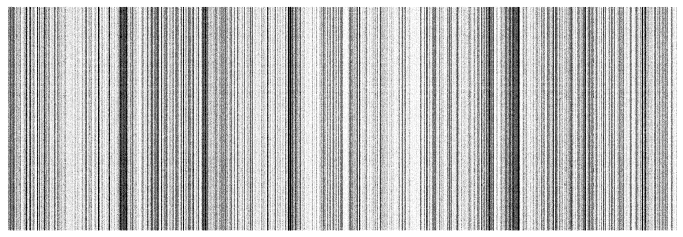

<32828x98419 sparse matrix of type '<class 'numpy.float64'>'
	with 2959482 stored elements in COOrdinate format>

In [133]:
import numpy as np
from scipy.sparse import coo_matrix

plt.rcParams["figure.figsize"] = [12,12]

fig = plt.figure()
m = tfidf.tocoo()
ax = plot_coo_matrix(m, fig)

print(tfidf.shape)

plt.show()

m

In [134]:
nmf = NMF(n_components=20, random_state=1,
              alpha=stat.alpha, l1_ratio=.1, verbose=False,
              init='nndsvd', max_iter=stat.max_iterations).fit(tfidf)

In [139]:
W = coo_matrix(nmf.components_)
fig = plt.figure()
ax = plot_coo_matrix(W,fig)
plt.show()

print(W.shape)



(20, 98419)


In [141]:
H = coo_matrix(nmf.transform(tfidf))
fig = plt.figure()
ax = plot_coo_matrix(H,fig)
plt.show()

print(H.shape)

(32828, 20)


In [144]:
fig = plt.figure()
ax = plot_coo_matrix(W,fig)
ax = plot_coo_matrix(H,fig)
plt.show()